# Stage 1. Data loading and preprocessing

Stage 1 — Setup: This cell imports all required libraries and utilities for the project: core Python modules, PyTorch, TorchVision transforms, timm models, metrics, plotting, and helpers used throughout the notebook.

In [1]:
from __future__ import annotations

# Standard library
import json
import math
from pathlib import Path
import os
import sys

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from PIL import Image
from tqdm import tqdm

/home/ubuntu/yandex_dl_course_3/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Stage 1 — Setup: This cell defines configuration constants — paths, dev-mode toggles, split fraction, image size and normalization, loader params, seed, model hyperparameters, and checkpoint path.


In [2]:
# Configuration constants

# root directory of the data
DATA_ROOT = Path("data")
TRAIN_DATA_ROOT = DATA_ROOT / "train"  # directory of the training data
TEST_DATA_ROOT = DATA_ROOT / "test"   # directory of the test data

# Development mode: limit dataset sizes for fast iteration
DEV_MODE = False
DEV_MAX_TRAIN_SAMPLES = 32
DEV_MAX_VAL_SAMPLES = 8
DEV_MAX_TEST_SAMPLES = 16

# Dataset split
VAL_SPLIT_FRACTION = 0.2

# Preprocessing
IM_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# DataLoader configuration
BATCH_SIZE = 32
#_cpu_cnt = os.cpu_count() or 2
#NUM_WORKERS = 0 if sys.platform.startswith("win") else max(_cpu_cnt - 1, 1)
NUM_WORKERS = 0
PIN_MEMORY = torch.cuda.is_available()
PREFETCH_FACTOR = 2

# Reproducibility
SEED = 42

# Model/optimization
MODEL_NAME = "rexnet_150"
LEARNING_RATE = 3e-4
EPOCHS = 40
if DEV_MODE:
    EPOCHS = 1

# Checkpointing
CHECKPOINT_PATH = DATA_ROOT

Stage 1 — Data: This cell defines the custom `PillDataset` used to read images and labels from the directory structure.

In [3]:
class PillDataset(Dataset[tuple[torch.Tensor, int]]):

    def __init__(self, root: Path, class_names: list[str],
                 transform: Compose | None = None) -> None:
        self.root: Path = Path(root)
        self.class_names: list[str] = class_names
        self.transform: Compose | None = transform
        self.class_to_idx: dict[str, int] = {
            name: idx for idx, name in enumerate(class_names)}

        # Collect all image paths and labels, assuming .jpg extension
        self.samples: list[tuple[Path, int]] = []
        self._collect_samples()

        if not self.samples:  # Check if the list is empty
            raise ValueError(f"No valid images found in {root}")

    def _collect_samples(self) -> None:
        """Collect all valid image samples from the dataset, assuming .jpg."""
        for class_name in self.class_names:
            class_dir = self.root / class_name
            class_idx = self.class_to_idx[class_name]

            if not class_dir.is_dir(): # Skip if not a directory
                continue

            # Find all .jpg files
            for img_path in class_dir.iterdir():
                if img_path.is_file() and img_path.suffix.lower() == '.jpg':
                    self.samples.append((img_path, class_idx))

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        img_path, label = self.samples[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image_tensor = self.transform(image)
        else:
            # Convert to tensor manually if no transform
            image_tensor = (torch.tensor(np.array(image)).permute(2, 0, 1)
                            .float() / 255.0)

        return image_tensor, label

Stage 1 — Data: This cell enumerates class names from `data/train`, persists the ordered list to `class_index.json`, and prints a preview.


In [4]:
# Infer class list from folder names under data/train
class_names = sorted([p.name for p in TRAIN_DATA_ROOT.iterdir() if p.is_dir()])

# Persist ordered class list for reporting
with open(DATA_ROOT / "class_index.json", "w", encoding="utf-8") as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)

print(f"Discovered {len(class_names)} classes")
print(class_names[:10])

Discovered 84 classes
['acc_long_600_mg', 'advil_ultra_forte', 'akineton_2_mg', 'algoflex_forte_dolo_400_mg', 'algoflex_rapid_400_mg', 'algopyrin_500_mg', 'ambroxol_egis_30_mg', 'apranax_550_mg', 'aspirin_ultra_500_mg', 'atoris_20_mg']


Stage 1 — Data: This cell defines the preprocessing pipeline (resize, tensorize, normalize) applied to all images.


In [5]:
# Define preprocessing transforms exactly as in the reference script

tfs = Compose([
    Resize((IM_SIZE, IM_SIZE)),
    ToTensor(),
    Normalize(mean=MEAN, std=STD),
])

print("Transforms ready.")

Transforms ready.


Stage 1 — Data: This cell constructs the `PillDataset`, splits into train/val with a fixed seed, optionally subsamples in dev mode, and prints split sizes.


In [6]:
# Create full training dataset with transforms
full_dataset = PillDataset(TRAIN_DATA_ROOT, class_names, transform=tfs)
num_items = len(full_dataset)
val_size = int(math.floor(VAL_SPLIT_FRACTION * num_items))
train_size = num_items - val_size

# Fixed seed for deterministic split
generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size], generator=generator
)

# Optionally limit dataset sizes in DEV_MODE
if DEV_MODE:
    train_dataset = torch.utils.data.Subset(
        train_dataset, range(min(len(train_dataset), DEV_MAX_TRAIN_SAMPLES)))
    val_dataset = torch.utils.data.Subset(
        val_dataset, range(min(len(val_dataset), DEV_MAX_VAL_SAMPLES)))


print(f"Train items: {len(train_dataset)}  |  Val items: {len(val_dataset)}"
      f"  |  Total: {len(train_dataset) + len(val_dataset)}")

Train items: 1882  |  Val items: 470  |  Total: 2352


Stage 1 — Data: This cell shows a random 4x4 grid of training samples (inverse-normalized) to visually inspect labels and image quality.


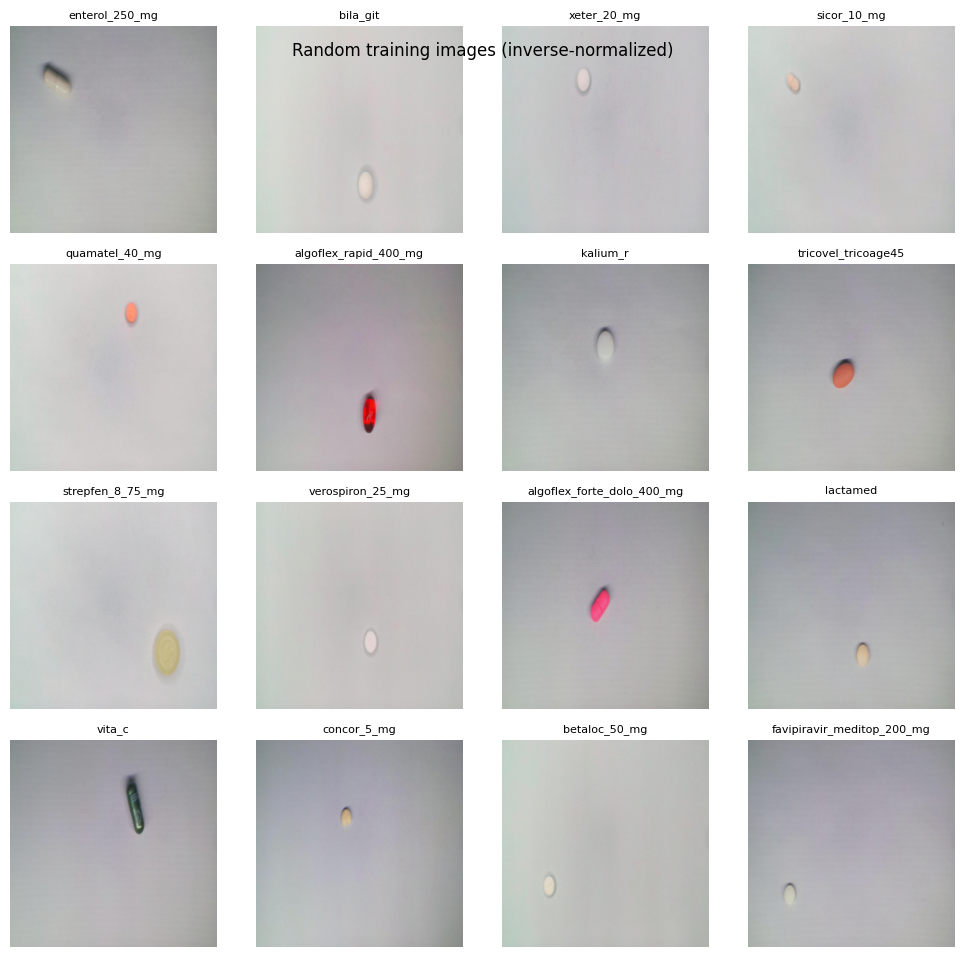

In [7]:
# Show a 4x4 grid of random training images for EDA (from the train split)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
_k = min(16, len(train_dataset)) # Corrected from train_subset
indices = np.random.choice(len(train_dataset), _k, replace=False)
for ax, idx in zip(axes.flat, indices):
    img, label = train_dataset[idx] # Corrected from train_subset
    npimg = img.numpy().transpose(1, 2, 0)
    npimg = npimg * np.array(STD) + np.array(MEAN)
    npimg = np.clip(npimg, 0, 1)
    ax.imshow(npimg)
    ax.set_title(class_names[label], fontsize=8)
    ax.axis("off")
plt.suptitle("Random training images (inverse-normalized)", y=0.92)
plt.tight_layout()
plt.show()

Stage 1 — Data: This cell builds `DataLoader`s for train/val/test with pinned memory, workers, and optional prefetch; it also summarizes dataset/batch stats.


In [8]:
# DataLoader configuration following PyTorch best practices

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=NUM_WORKERS > 0,
    **({"prefetch_factor": PREFETCH_FACTOR} if NUM_WORKERS > 0 else {})
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=NUM_WORKERS > 0,
    **({"prefetch_factor": PREFETCH_FACTOR} if NUM_WORKERS > 0 else {})
)

# Create test dataset using custom PillDataset (same transforms)
test_dataset = PillDataset(TEST_DATA_ROOT, class_names, transform=tfs)
_test_idx = list(range(len(test_dataset)))
if DEV_MODE:
    _test_idx = _test_idx[:DEV_MAX_TEST_SAMPLES]
test_subset = torch.utils.data.Subset(test_dataset, _test_idx)
test_loader = DataLoader(
    test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=NUM_WORKERS > 0,
    **({"prefetch_factor": PREFETCH_FACTOR} if NUM_WORKERS > 0 else {})
)

print(
    f"Batch size: {BATCH_SIZE} | Num workers: {NUM_WORKERS} | "
    f"Pin memory: {PIN_MEMORY}\n"
    f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | "
    f"Test batches: {len(test_loader)}\n"
    f"Train images: {len(train_dataset)} | Val images: {len(val_dataset)} | "
    f"Test images: {len(test_subset)}\n"
    f"Number of classes: {len(class_names)}"
)

Batch size: 32 | Num workers: 0 | Pin memory: True
Train batches: 59 | Val batches: 15 | Test batches: 16
Train images: 1882 | Val images: 470 | Test images: 504
Number of classes: 84


# Stage 2. Model declaration

Stage 2 — Model: This cell selects the device (CUDA or CPU) and sets precision flags; it starts the model declaration stage.

In [9]:
# Set up device and declare the pretrained ReXNet-150 model.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    # torch.backends.cudnn.benchmark = True # Disable to avoid "Not enough SMs" error
    torch.set_float32_matmul_precision("high")

Using device: cuda


Stage 2 — Model: This cell creates the pretrained ReXNet-150 with the correct number of classes and attempts to compile it.


In [10]:
model = timm.create_model(MODEL_NAME, pretrained=True,
                          num_classes=len(class_names))

# Compile the model for potential performance improvements
if torch.cuda.is_available(): # Compile only if CUDA is available
    try:
        model = torch.compile(model)
        print("Model compiled successfully.")
    except Exception as e:
        print(f"Model compilation failed: {e}")
        print("Proceeding without compilation.")

print(type(model).__name__)

Model compiled successfully.
OptimizedModule


Stage 2 — Model: This cell rebuilds the model, freezes the backbone, keeps the classifier head trainable, and compiles for speed.


In [11]:
# Move model to device and verify output shape on a dummy batch
model = timm.create_model(MODEL_NAME, pretrained=True,
                          num_classes=len(class_names))

# Freeze backbone; train classification head only for fastest convergence (before compile)
for p in model.parameters():
    p.requires_grad = False
for p in model.head.parameters():
    p.requires_grad = True

# Compile the model for potential performance improvements
if torch.cuda.is_available(): # Compile only if CUDA is available
    try:
        model = torch.compile(model)
        print("Model compiled successfully.")
    except Exception as e:
        print(f"Model compilation failed: {e}")
        print("Proceeding without compilation.")

print(type(model).__name__)

Model compiled successfully.
OptimizedModule


Stage 2 — Model: This cell sanity-checks the model’s output shape on a dummy batch and ensures device/format are set for efficient inference.


In [12]:
# Move model to device and verify output shape on a dummy batch
model = model.to(device)
if torch.cuda.is_available():
    model = model.to(memory_format=torch.channels_last)
model.eval()

with torch.no_grad():
    dummy = torch.randn(2, 3, IM_SIZE, IM_SIZE, device=device)
    if torch.cuda.is_available():
        dummy = dummy.to(memory_format=torch.channels_last)
    logits = model(dummy)

assert (logits.shape[0] == 2 and
        logits.shape[1] == len(class_names)
       ), "Unexpected output shape from model"

print("Logits shape:", tuple(logits.shape))

W0913 16:27:57.196000 8564 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


Logits shape: (2, 84)


Stage 3 — Training: This cell sets up the training components — loss function (cross-entropy), optimizer (Adam on head), and AMP scaler.


In [13]:
# Stage 3. Training

# Training setup

# Define loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=LEARNING_RATE)

# Mixed precision configuration (new API)
AMP = torch.cuda.is_available()
scaler = torch.amp.GradScaler('cuda', enabled=AMP)

print("Training setup ready.")


Training setup ready.


Stage 3 — Training: This cell defines the training loop `train_one_epoch`, computing loss/accuracy and performing optimizer updates with mixed precision.


In [14]:
def train_one_epoch(epoch_index: int) -> tuple[float, float]:
    model.train()
    running_loss = 0.0
    running_correct = 0

    for images, labels in tqdm(train_loader, desc=f"Train {epoch_index}"):
        images = images.to(device, non_blocking=True)
        if AMP:
            images = images.to(memory_format=torch.channels_last)
        labels = labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=AMP):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()

    avg_loss = running_loss / max(len(train_loader), 1)
    avg_acc = running_correct / max(len(train_loader.dataset), 1)
    print(f"Epoch {epoch_index}: train loss={avg_loss:.4f} acc={avg_acc:.4f}")
    return avg_loss, avg_acc

Stage 3 — Training: This cell defines the validation loop `validate_one_epoch`, computing average loss and accuracy over the validation set.


In [15]:
def validate_one_epoch(epoch_index: int) -> tuple[float, float]:
    model.eval()
    running_loss = 0.0
    running_correct = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Val {epoch_index}"):
            images = images.to(device, non_blocking=True)
            if AMP:
                images = images.to(memory_format=torch.channels_last)
            labels = labels.to(device)

            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=AMP):
                outputs = model(images)
                loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()

    avg_loss = running_loss / max(len(val_loader), 1)
    avg_acc = running_correct / max(len(val_loader.dataset), 1)
    print(f"Epoch {epoch_index}: val   loss={avg_loss:.4f} acc={avg_acc:.4f}")
    return avg_loss, avg_acc

Stage 3 — Training: This cell runs the multi-epoch training loop, logs train/val metrics, and saves best checkpoints by validation loss.


In [16]:
# Training loop with checkpointing

# Run multiple epochs, track best validation loss, and save the best model to `meds_classifier.pt`.

best_val_loss = float("inf")

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(epoch)
    vl, va = validate_one_epoch(epoch)

    history["train_loss"].append(tl)
    history["train_acc"].append(ta)
    history["val_loss"].append(vl)
    history["val_acc"].append(va)

    print(f"Epoch {epoch} summary → train: loss={tl:.4f} acc={ta:.4f} | val: loss={vl:.4f} acc={va:.4f}")

    if vl < best_val_loss:
        best_val_loss = vl
        torch.save(model.state_dict(), CHECKPOINT_PATH / f"pill_classifier_{epoch}_epoch.pt")
        # This is for formal compliance with the assignment requirements.
        torch.save(model.state_dict(), CHECKPOINT_PATH / "meds_classifier.pt")
        print(f"Saved best model at epoch {epoch} with val loss {vl:.4f}")

print("Training complete.")

Train 1: 100%|██████████| 59/59 [03:32<00:00,  3.59s/it] 


Epoch 1: train loss=4.4742 acc=0.0239


Val 1: 100%|██████████| 15/15 [01:21<00:00,  5.44s/it]


Epoch 1: val   loss=4.2569 acc=0.0319
Epoch 1 summary → train: loss=4.4742 acc=0.0239 | val: loss=4.2569 acc=0.0319
Saved best model at epoch 1 with val loss 4.2569


Train 2: 100%|██████████| 59/59 [02:37<00:00,  2.67s/it]


Epoch 2: train loss=3.9714 acc=0.0978


Val 2: 100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


Epoch 2: val   loss=3.8700 acc=0.1106
Epoch 2 summary → train: loss=3.9714 acc=0.0978 | val: loss=3.8700 acc=0.1106
Saved best model at epoch 2 with val loss 3.8700


Train 3: 100%|██████████| 59/59 [02:39<00:00,  2.71s/it]


Epoch 3: train loss=3.5864 acc=0.2163


Val 3: 100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


Epoch 3: val   loss=3.5523 acc=0.2277
Epoch 3 summary → train: loss=3.5864 acc=0.2163 | val: loss=3.5523 acc=0.2277
Saved best model at epoch 3 with val loss 3.5523


Train 4: 100%|██████████| 59/59 [02:35<00:00,  2.64s/it]


Epoch 4: train loss=3.2276 acc=0.3470


Val 4: 100%|██████████| 15/15 [00:38<00:00,  2.60s/it]


Epoch 4: val   loss=3.2888 acc=0.3064
Epoch 4 summary → train: loss=3.2276 acc=0.3470 | val: loss=3.2888 acc=0.3064
Saved best model at epoch 4 with val loss 3.2888


Train 5: 100%|██████████| 59/59 [02:38<00:00,  2.69s/it]


Epoch 5: train loss=2.9230 acc=0.4841


Val 5: 100%|██████████| 15/15 [00:39<00:00,  2.63s/it]


Epoch 5: val   loss=3.0338 acc=0.3745
Epoch 5 summary → train: loss=2.9230 acc=0.4841 | val: loss=3.0338 acc=0.3745
Saved best model at epoch 5 with val loss 3.0338


Train 6: 100%|██████████| 59/59 [02:40<00:00,  2.72s/it]


Epoch 6: train loss=2.6022 acc=0.5930


Val 6: 100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


Epoch 6: val   loss=2.8012 acc=0.4319
Epoch 6 summary → train: loss=2.6022 acc=0.5930 | val: loss=2.8012 acc=0.4319
Saved best model at epoch 6 with val loss 2.8012


Train 7: 100%|██████████| 59/59 [02:40<00:00,  2.71s/it]


Epoch 7: train loss=2.3440 acc=0.6711


Val 7: 100%|██████████| 15/15 [00:40<00:00,  2.69s/it]


Epoch 7: val   loss=2.6118 acc=0.4979
Epoch 7 summary → train: loss=2.3440 acc=0.6711 | val: loss=2.6118 acc=0.4979
Saved best model at epoch 7 with val loss 2.6118


Train 8: 100%|██████████| 59/59 [02:40<00:00,  2.71s/it]


Epoch 8: train loss=2.1410 acc=0.7343


Val 8: 100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


Epoch 8: val   loss=2.4272 acc=0.5511
Epoch 8 summary → train: loss=2.1410 acc=0.7343 | val: loss=2.4272 acc=0.5511
Saved best model at epoch 8 with val loss 2.4272


Train 9: 100%|██████████| 59/59 [02:41<00:00,  2.74s/it]


Epoch 9: train loss=1.9302 acc=0.7816


Val 9: 100%|██████████| 15/15 [00:40<00:00,  2.71s/it]


Epoch 9: val   loss=2.2606 acc=0.5936
Epoch 9 summary → train: loss=1.9302 acc=0.7816 | val: loss=2.2606 acc=0.5936
Saved best model at epoch 9 with val loss 2.2606


Train 10: 100%|██████████| 59/59 [02:43<00:00,  2.78s/it]


Epoch 10: train loss=1.7438 acc=0.8114


Val 10: 100%|██████████| 15/15 [00:39<00:00,  2.61s/it]


Epoch 10: val   loss=2.1363 acc=0.6277
Epoch 10 summary → train: loss=1.7438 acc=0.8114 | val: loss=2.1363 acc=0.6277
Saved best model at epoch 10 with val loss 2.1363


Train 11: 100%|██████████| 59/59 [02:35<00:00,  2.64s/it]


Epoch 11: train loss=1.5844 acc=0.8618


Val 11: 100%|██████████| 15/15 [00:38<00:00,  2.59s/it]


Epoch 11: val   loss=1.9882 acc=0.6553
Epoch 11 summary → train: loss=1.5844 acc=0.8618 | val: loss=1.9882 acc=0.6553
Saved best model at epoch 11 with val loss 1.9882


Train 12: 100%|██████████| 59/59 [02:35<00:00,  2.64s/it]


Epoch 12: train loss=1.4423 acc=0.8757


Val 12: 100%|██████████| 15/15 [00:39<00:00,  2.60s/it]


Epoch 12: val   loss=1.8617 acc=0.6660
Epoch 12 summary → train: loss=1.4423 acc=0.8757 | val: loss=1.8617 acc=0.6660
Saved best model at epoch 12 with val loss 1.8617


Train 13: 100%|██████████| 59/59 [02:37<00:00,  2.67s/it]


Epoch 13: train loss=1.3163 acc=0.9049


Val 13: 100%|██████████| 15/15 [00:38<00:00,  2.57s/it]


Epoch 13: val   loss=1.7716 acc=0.7021
Epoch 13 summary → train: loss=1.3163 acc=0.9049 | val: loss=1.7716 acc=0.7021
Saved best model at epoch 13 with val loss 1.7716


Train 14: 100%|██████████| 59/59 [02:35<00:00,  2.63s/it]


Epoch 14: train loss=1.2236 acc=0.9060


Val 14: 100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


Epoch 14: val   loss=1.6691 acc=0.7128
Epoch 14 summary → train: loss=1.2236 acc=0.9060 | val: loss=1.6691 acc=0.7128
Saved best model at epoch 14 with val loss 1.6691


Train 15: 100%|██████████| 59/59 [02:35<00:00,  2.63s/it]


Epoch 15: train loss=1.1159 acc=0.9261


Val 15: 100%|██████████| 15/15 [00:39<00:00,  2.61s/it]


Epoch 15: val   loss=1.6069 acc=0.7277
Epoch 15 summary → train: loss=1.1159 acc=0.9261 | val: loss=1.6069 acc=0.7277
Saved best model at epoch 15 with val loss 1.6069


Train 16: 100%|██████████| 59/59 [02:34<00:00,  2.62s/it]


Epoch 16: train loss=1.0287 acc=0.9437


Val 16: 100%|██████████| 15/15 [00:38<00:00,  2.60s/it]


Epoch 16: val   loss=1.5267 acc=0.7596
Epoch 16 summary → train: loss=1.0287 acc=0.9437 | val: loss=1.5267 acc=0.7596
Saved best model at epoch 16 with val loss 1.5267


Train 17: 100%|██████████| 59/59 [02:36<00:00,  2.65s/it]


Epoch 17: train loss=0.9546 acc=0.9506


Val 17: 100%|██████████| 15/15 [00:38<00:00,  2.58s/it]


Epoch 17: val   loss=1.4590 acc=0.7660
Epoch 17 summary → train: loss=0.9546 acc=0.9506 | val: loss=1.4590 acc=0.7660
Saved best model at epoch 17 with val loss 1.4590


Train 18: 100%|██████████| 59/59 [02:34<00:00,  2.62s/it]


Epoch 18: train loss=0.8466 acc=0.9575


Val 18: 100%|██████████| 15/15 [00:38<00:00,  2.59s/it]


Epoch 18: val   loss=1.4093 acc=0.7681
Epoch 18 summary → train: loss=0.8466 acc=0.9575 | val: loss=1.4093 acc=0.7681
Saved best model at epoch 18 with val loss 1.4093


Train 19: 100%|██████████| 59/59 [02:35<00:00,  2.64s/it]


Epoch 19: train loss=0.8156 acc=0.9575


Val 19: 100%|██████████| 15/15 [00:38<00:00,  2.59s/it]


Epoch 19: val   loss=1.3445 acc=0.7894
Epoch 19 summary → train: loss=0.8156 acc=0.9575 | val: loss=1.3445 acc=0.7894
Saved best model at epoch 19 with val loss 1.3445


Train 20: 100%|██████████| 59/59 [02:36<00:00,  2.65s/it]


Epoch 20: train loss=0.7446 acc=0.9596


Val 20: 100%|██████████| 15/15 [00:38<00:00,  2.53s/it]


Epoch 20: val   loss=1.2994 acc=0.7915
Epoch 20 summary → train: loss=0.7446 acc=0.9596 | val: loss=1.2994 acc=0.7915
Saved best model at epoch 20 with val loss 1.2994


Train 21: 100%|██████████| 59/59 [02:35<00:00,  2.63s/it]


Epoch 21: train loss=0.6800 acc=0.9787


Val 21: 100%|██████████| 15/15 [00:38<00:00,  2.59s/it]


Epoch 21: val   loss=1.2538 acc=0.8064
Epoch 21 summary → train: loss=0.6800 acc=0.9787 | val: loss=1.2538 acc=0.8064
Saved best model at epoch 21 with val loss 1.2538


Train 22: 100%|██████████| 59/59 [02:35<00:00,  2.63s/it]


Epoch 22: train loss=0.6409 acc=0.9761


Val 22: 100%|██████████| 15/15 [00:38<00:00,  2.60s/it]


Epoch 22: val   loss=1.1925 acc=0.8043
Epoch 22 summary → train: loss=0.6409 acc=0.9761 | val: loss=1.1925 acc=0.8043
Saved best model at epoch 22 with val loss 1.1925


Train 23: 100%|██████████| 59/59 [02:35<00:00,  2.64s/it]


Epoch 23: train loss=0.6038 acc=0.9809


Val 23: 100%|██████████| 15/15 [00:38<00:00,  2.57s/it]


Epoch 23: val   loss=1.1760 acc=0.8149
Epoch 23 summary → train: loss=0.6038 acc=0.9809 | val: loss=1.1760 acc=0.8149
Saved best model at epoch 23 with val loss 1.1760


Train 24: 100%|██████████| 59/59 [02:35<00:00,  2.63s/it]


Epoch 24: train loss=0.5809 acc=0.9782


Val 24: 100%|██████████| 15/15 [00:38<00:00,  2.57s/it]


Epoch 24: val   loss=1.1455 acc=0.8000
Epoch 24 summary → train: loss=0.5809 acc=0.9782 | val: loss=1.1455 acc=0.8000
Saved best model at epoch 24 with val loss 1.1455


Train 25: 100%|██████████| 59/59 [02:34<00:00,  2.62s/it]


Epoch 25: train loss=0.5476 acc=0.9819


Val 25: 100%|██████████| 15/15 [00:38<00:00,  2.59s/it]


Epoch 25: val   loss=1.0945 acc=0.8255
Epoch 25 summary → train: loss=0.5476 acc=0.9819 | val: loss=1.0945 acc=0.8255
Saved best model at epoch 25 with val loss 1.0945


Train 26: 100%|██████████| 59/59 [02:34<00:00,  2.63s/it]


Epoch 26: train loss=0.4986 acc=0.9883


Val 26: 100%|██████████| 15/15 [00:38<00:00,  2.59s/it]


Epoch 26: val   loss=1.0632 acc=0.8277
Epoch 26 summary → train: loss=0.4986 acc=0.9883 | val: loss=1.0632 acc=0.8277
Saved best model at epoch 26 with val loss 1.0632


Train 27: 100%|██████████| 59/59 [02:36<00:00,  2.66s/it]


Epoch 27: train loss=0.4606 acc=0.9851


Val 27: 100%|██████████| 15/15 [00:38<00:00,  2.57s/it]


Epoch 27: val   loss=1.0368 acc=0.8362
Epoch 27 summary → train: loss=0.4606 acc=0.9851 | val: loss=1.0368 acc=0.8362
Saved best model at epoch 27 with val loss 1.0368


Train 28: 100%|██████████| 59/59 [02:34<00:00,  2.63s/it]


Epoch 28: train loss=0.4416 acc=0.9878


Val 28: 100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


Epoch 28: val   loss=1.0168 acc=0.8362
Epoch 28 summary → train: loss=0.4416 acc=0.9878 | val: loss=1.0168 acc=0.8362
Saved best model at epoch 28 with val loss 1.0168


Train 29: 100%|██████████| 59/59 [02:35<00:00,  2.63s/it]


Epoch 29: train loss=0.4197 acc=0.9910


Val 29: 100%|██████████| 15/15 [00:38<00:00,  2.57s/it]


Epoch 29: val   loss=0.9780 acc=0.8277
Epoch 29 summary → train: loss=0.4197 acc=0.9910 | val: loss=0.9780 acc=0.8277
Saved best model at epoch 29 with val loss 0.9780


Train 30: 100%|██████████| 59/59 [02:43<00:00,  2.76s/it]


Epoch 30: train loss=0.3903 acc=0.9888


Val 30: 100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


Epoch 30: val   loss=0.9592 acc=0.8319
Epoch 30 summary → train: loss=0.3903 acc=0.9888 | val: loss=0.9592 acc=0.8319
Saved best model at epoch 30 with val loss 0.9592


Train 31: 100%|██████████| 59/59 [02:43<00:00,  2.77s/it]


Epoch 31: train loss=0.3717 acc=0.9894


Val 31: 100%|██████████| 15/15 [00:40<00:00,  2.70s/it]


Epoch 31: val   loss=0.9423 acc=0.8383
Epoch 31 summary → train: loss=0.3717 acc=0.9894 | val: loss=0.9423 acc=0.8383
Saved best model at epoch 31 with val loss 0.9423


Train 32: 100%|██████████| 59/59 [02:41<00:00,  2.74s/it]


Epoch 32: train loss=0.3480 acc=0.9942


Val 32: 100%|██████████| 15/15 [00:39<00:00,  2.67s/it]


Epoch 32: val   loss=0.9333 acc=0.8404
Epoch 32 summary → train: loss=0.3480 acc=0.9942 | val: loss=0.9333 acc=0.8404
Saved best model at epoch 32 with val loss 0.9333


Train 33: 100%|██████████| 59/59 [02:43<00:00,  2.76s/it]


Epoch 33: train loss=0.3396 acc=0.9942


Val 33: 100%|██████████| 15/15 [00:40<00:00,  2.67s/it]


Epoch 33: val   loss=0.9049 acc=0.8383
Epoch 33 summary → train: loss=0.3396 acc=0.9942 | val: loss=0.9049 acc=0.8383
Saved best model at epoch 33 with val loss 0.9049


Train 34: 100%|██████████| 59/59 [02:39<00:00,  2.70s/it]


Epoch 34: train loss=0.3168 acc=0.9936


Val 34: 100%|██████████| 15/15 [00:38<00:00,  2.59s/it]


Epoch 34: val   loss=0.8949 acc=0.8511
Epoch 34 summary → train: loss=0.3168 acc=0.9936 | val: loss=0.8949 acc=0.8511
Saved best model at epoch 34 with val loss 0.8949


Train 35: 100%|██████████| 59/59 [02:35<00:00,  2.64s/it]


Epoch 35: train loss=0.2926 acc=0.9963


Val 35: 100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


Epoch 35: val   loss=0.8792 acc=0.8468
Epoch 35 summary → train: loss=0.2926 acc=0.9963 | val: loss=0.8792 acc=0.8468
Saved best model at epoch 35 with val loss 0.8792


Train 36: 100%|██████████| 59/59 [02:35<00:00,  2.63s/it]


Epoch 36: train loss=0.2848 acc=0.9963


Val 36: 100%|██████████| 15/15 [00:38<00:00,  2.57s/it]


Epoch 36: val   loss=0.8586 acc=0.8532
Epoch 36 summary → train: loss=0.2848 acc=0.9963 | val: loss=0.8586 acc=0.8532
Saved best model at epoch 36 with val loss 0.8586


Train 37: 100%|██████████| 59/59 [02:35<00:00,  2.64s/it]


Epoch 37: train loss=0.2758 acc=0.9963


Val 37: 100%|██████████| 15/15 [00:39<00:00,  2.60s/it]


Epoch 37: val   loss=0.8388 acc=0.8383
Epoch 37 summary → train: loss=0.2758 acc=0.9963 | val: loss=0.8388 acc=0.8383
Saved best model at epoch 37 with val loss 0.8388


Train 38: 100%|██████████| 59/59 [02:36<00:00,  2.65s/it]


Epoch 38: train loss=0.2652 acc=0.9952


Val 38: 100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


Epoch 38: val   loss=0.8243 acc=0.8447
Epoch 38 summary → train: loss=0.2652 acc=0.9952 | val: loss=0.8243 acc=0.8447
Saved best model at epoch 38 with val loss 0.8243


Train 39: 100%|██████████| 59/59 [02:36<00:00,  2.66s/it]


Epoch 39: train loss=0.2550 acc=0.9973


Val 39: 100%|██████████| 15/15 [00:38<00:00,  2.57s/it]


Epoch 39: val   loss=0.8076 acc=0.8532
Epoch 39 summary → train: loss=0.2550 acc=0.9973 | val: loss=0.8076 acc=0.8532
Saved best model at epoch 39 with val loss 0.8076


Train 40: 100%|██████████| 59/59 [02:40<00:00,  2.73s/it]


Epoch 40: train loss=0.2410 acc=0.9957


Val 40: 100%|██████████| 15/15 [00:40<00:00,  2.72s/it]

Epoch 40: val   loss=0.7955 acc=0.8468
Epoch 40 summary → train: loss=0.2410 acc=0.9957 | val: loss=0.7955 acc=0.8468
Saved best model at epoch 40 with val loss 0.7955
Training complete.


Stage 3 — Training: This cell plots learning curves for train/validation loss across epochs to visualize convergence and overfitting/underfitting.


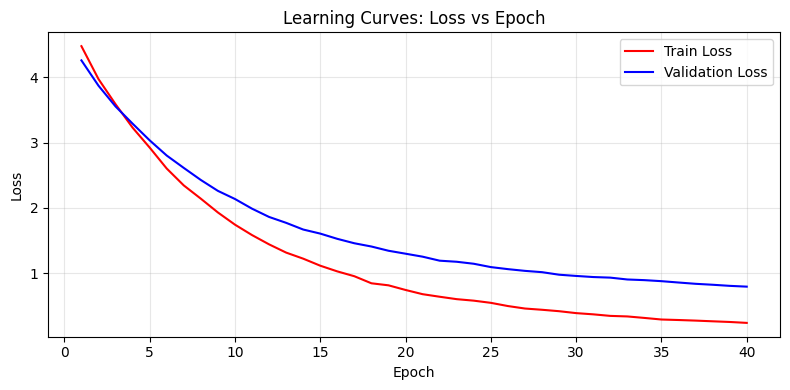

In [17]:
# Plot train/validation loss over epochs for better progress visibility.

epochs_axis = list(range(1, len(history["train_loss"]) + 1))
fig = plt.figure(figsize=(8, 4))
plt.plot(epochs_axis, history["train_loss"], label="Train Loss", c="red")
plt.plot(epochs_axis, history["val_loss"], label="Validation Loss", c="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves: Loss vs Epoch")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Stage 4 — Evaluation: This cell loads the best checkpoint, fixes key prefixes if compiled, moves the model to the device, and switches to eval mode.


In [19]:
# Stage 4. Evaluation and analysis

# Load best checkpoint

# Find the checkpoint file with the highest epoch number
checkpoint_files = list(CHECKPOINT_PATH.glob("pill_classifier_*_epoch.pt"))
if not checkpoint_files:
    raise FileNotFoundError("No checkpoint files found.")

latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.stem.split('_')[2]))

# Rebuild a fresh, uncompiled model to ensure key names match the checkpoint
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(class_names))

# Load state dict from disk
state_dict = torch.load(latest_checkpoint, map_location="cpu")

# If this checkpoint was saved from a compiled model, strip the wrapper prefix
if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
    state_dict = {k.replace("_orig_mod.", "", 1): v for k, v in state_dict.items()}

# Load with non-strict to tolerate minor buffer diffs across PyTorch versions
model.load_state_dict(state_dict, strict=False)

# Move to device and switch to eval
model = model.to(device)
model.eval()

# Optionally compile for faster inference (after weights are loaded)
if torch.cuda.is_available():
    try:
        model = torch.compile(model)
    except Exception as e:
        print(f"Model compilation for inference skipped: {e}")

print(f"Loaded best checkpoint from {latest_checkpoint} and set model to eval.")

Loaded best checkpoint from data/pill_classifier_40_epoch.pt and set model to eval.


Stage 4 — Evaluation: This cell runs inference on the test set and collects `y_true` and `y_pred` for downstream metrics.


In [20]:
# Collect predictions and ground-truth labels from the test set.

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device, non_blocking=True)
        if torch.cuda.is_available():
            images = images.to(memory_format=torch.channels_last)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=torch.cuda.is_available()):
            outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().tolist()
        y_pred.extend(preds)
        y_true.extend(labels.tolist())

print(f"\nCollected predictions for {len(y_true)} test items")

Evaluating: 100%|██████████| 16/16 [01:29<00:00,  5.58s/it]


Collected predictions for 504 test items


Stage 4 — Evaluation: Quick check that the checkpoint directory exists on disk.


In [21]:
print(f"{CHECKPOINT_PATH} exists:", Path(CHECKPOINT_PATH).exists())

data exists: True


Stage 4 — Evaluation: This cell prints overall accuracy and a detailed per-class classification report (precision/recall/F1), including macro averages.


In [25]:
# Compute metrics and print macro metrics first, then the full table (no duplicates)
_report_dict = classification_report(
    y_true, y_pred, target_names=class_names, digits=3, output_dict=True
)
macro_prec = _report_dict["macro avg"]["precision"]
macro_rec = _report_dict["macro avg"]["recall"]
macro_f1 = _report_dict["macro avg"]["f1-score"]
acc = accuracy_score(y_true, y_pred)

print(f"Macro averages → precision={macro_prec:.3f} recall={macro_rec:.3f} f1={macro_f1:.3f}")
print(f"Test accuracy: {acc:.4f}")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

Macro averages → precision=0.897 recall=0.883 f1=0.881
Test accuracy: 0.8829
                                  precision    recall  f1-score   support

                 acc_long_600_mg      1.000     1.000     1.000         6
               advil_ultra_forte      1.000     1.000     1.000         6
                   akineton_2_mg      1.000     1.000     1.000         6
      algoflex_forte_dolo_400_mg      1.000     1.000     1.000         6
           algoflex_rapid_400_mg      1.000     1.000     1.000         6
                algopyrin_500_mg      0.714     0.833     0.769         6
             ambroxol_egis_30_mg      1.000     0.833     0.909         6
                  apranax_550_mg      0.857     1.000     0.923         6
            aspirin_ultra_500_mg      1.000     1.000     1.000         6
                    atoris_20_mg      0.857     1.000     0.923         6
         atorvastatin_teva_20_mg      0.833     0.833     0.833         6
                   betaloc_50_mg  

# Stage 4 — Required analysis (answers)

- **Overall test metrics**:
  - **Accuracy**: 0.8829 (≥ 0.75 target)
  - **Macro averages**: Precision=0.897, Recall=0.883, F1=0.881

- **1) Top‑5 classes with most errors (lowest recall)**:
  - `naturland_d_vitamin_forte` — recall=0.333 (support=6)
  - `jutavit_cink` — recall=0.500 (support=6)
  - `kalcium_magnezium_cink` — recall=0.500 (support=6)
  - `novo_c_plus` — recall=0.500 (support=6)
  - `teva_ambrobene_30_mg` — recall=0.500 (support=6)

- **2) Why these fail (plausible causes)**:
  - High visual similarity to nearby classes (shape/color/print), leading to confusions.
  - Small support (n=6) per class → higher variance; borderline cases dominate.
  - Lighting/viewpoint/shine patterns not covered by current augmentations.
  - Packaging/label text cues too small at 224×224; model relies on weak color cues.

- **3) Classes with zero errors (recall = 1.0)**:
  - `acc_long_600_mg`, `advil_ultra_forte`, `akineton_2_mg`, `algoflex_forte_dolo_400_mg`, `algoflex_rapid_400_mg`, `apranax_550_mg`, `aspirin_ultra_500_mg`, `atoris_20_mg`, `betaloc_50_mg`, `c_vitamin_teva_500_mg`, `cataflam_50_mg`, `cataflam_dolo_25_mg`, `cold_fx`, `coldrex`, `concor_10_mg`, `condrosulf_800_mg`, `controloc_20_mg`, `coverex_4_mg`, `dorithricin_mentol`, `dulsevia_60_mg`, `favipiravir_meditop_200_mg`, `jutavit_c_vitamin`, `kalium_r`, `lactamed`, `laresin_10_mg`, `letrox_50_mikrogramm`, `merckformin_xr_1000_mg`, `metothyrin_10_mg`, `mezym_forte_10_000_egyseg`, `naprosyn_250_mg`, `nurofen_forte_400_mg`, `ocutein`, `olicard_60_mg`, `rubophen_500_mg`, `salazopyrin_en_500_mg`, `semicillin_500_mg`, `sinupret_forte`, `strepfen_8_75_mg`, `strepsils`, `teva_enterobene_2_mg`, `tritace_5_mg`, `urotrin`, `valeriana_teva`, `verospiron_25_mg`, `vitamin_d3_fresenius_1000_ne`, `xeter_20_mg`, `zadex_60_mg` (47 classes)

- **4) Why these succeed**:
  - Distinctive shapes/logos/markings; minimal overlap with visually similar classes.
  - Sufficient intra‑class consistency in capture conditions.
  - Strong discriminative local cues leveraged by the head even with frozen backbone.

- **5) How to improve the classifier further**:
  - Fine‑tune part or all of the backbone with a lower LR; cosine decay + warmup.
  - Targeted augmentation for low‑recall classes: stronger ColorJitter, RandomResizedCrop, TrivialAugment/RandAugment; optionally larger input (288–320) to read label text.
  - Rebalance: class‑weighted loss or `WeightedRandomSampler`; oversample the five weakest classes.
  - Regularization: label smoothing; mixup/cutmix to improve calibration and margin.
  - Inference: simple TTA (flips/crops) and `torch.inference_mode()` already used; consider `torch.compile` at eval when stable.
  - Architectures: try ConvNeXt‑T/S, EfficientNetV2‑S, ViT‑B/Swin‑T if compute allows.
  - Data hygiene: review mislabels/near‑duplicates; standardize lighting/backdrop.

- **6) Additional analyses to run**:
  - Confusion matrix: inspect top off‑diagonal pairs for the five weakest classes.
  - Per‑class support vs recall/F1 plot to highlight data scarcity impact.
  - Error buckets by lighting/viewpoint; visualize FN/FP grids per weak class.
  - Grad‑CAM/saliency on correct vs incorrect predictions for failure diagnosis.
  - Top‑k evaluation (top‑1 vs top‑5) to detect near‑misses.
